<a href="https://colab.research.google.com/github/padobrik/churn-prediction/blob/main/churn_prediction_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore feature warnings while construct plots
warnings.simplefilter(action='ignore', category=FutureWarning)

Import dataset:

In [ ]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

Basic dataset analysis:


In [ ]:
train_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
# Get general info about dataset:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Column 'TotalSpent' has string values, and also empty cells. According to the data about users' churn, we see that these empty values about total spent correspond to absence of any user's traffic. Thus, it is better to fill these cells with zeros instead of drop them from dataset:

In [ ]:
train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')
test_data['TotalSpent'] = pd.to_numeric(test_data['TotalSpent'], errors='coerce')

In [ ]:
train_data["TotalSpent"] = train_data.TotalSpent.fillna(0).astype(float)
test_data["TotalSpent"] = test_data.TotalSpent.fillna(0).astype(float)

In [ ]:
# Check NaN values in columns:
print('\033[1mNumber of NaN values in columns:\033[0m')
train_data.isna().sum()

Number of NaN values in columns:


ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Let's use given lists of columns from the baseline:

In [ ]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Now let's look at the distribution of the values provided to us across each parameter:

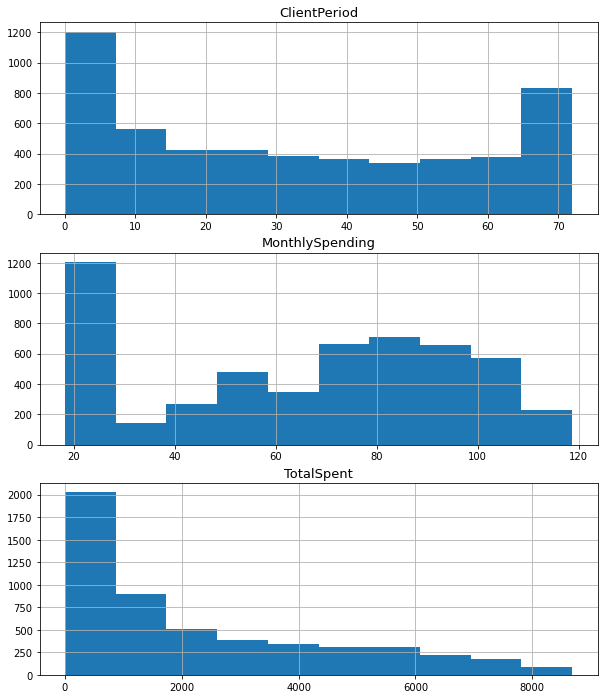

In [ ]:
# Plot distribution of numerical features:
fig, axs = plt.subplots(len(num_cols), figsize=(10, 12))
for n, col in enumerate(train_data[num_cols].columns):
    train_data[col].hist(ax=axs[n])
    axs[n].set_title(col, fontsize=13)

As we can see, there is no any serious outliers in numerical columns

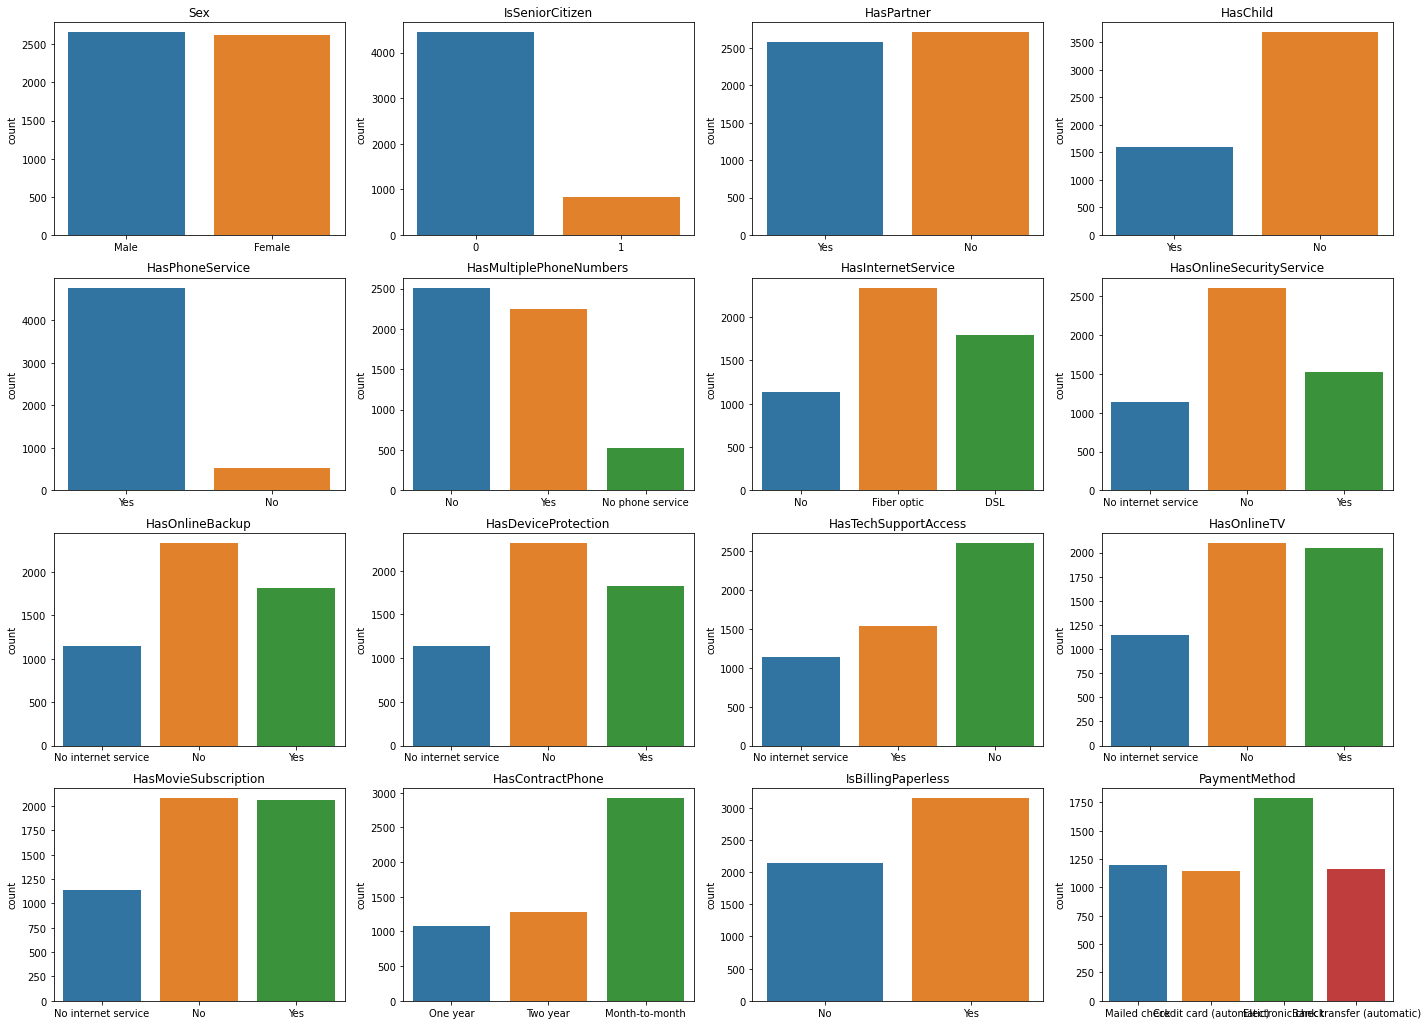

In [ ]:
# Plot distribution of categorical features:
f, axes = plt.subplots(4, 4, figsize=(24,18))
for column, ax in zip(cat_cols, axes.ravel()):
    sns.countplot(train_data[column], ax=ax)
    ax.set(xlabel=None)
    ax.set_title(column)

Categorical variables also do not show any anomalies

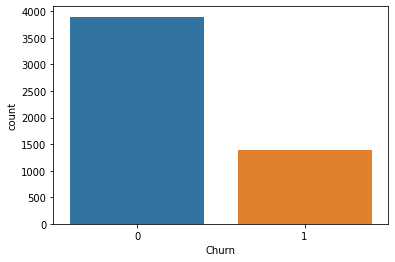

In [ ]:
# Target variable
sns.countplot(train_data[target_col])

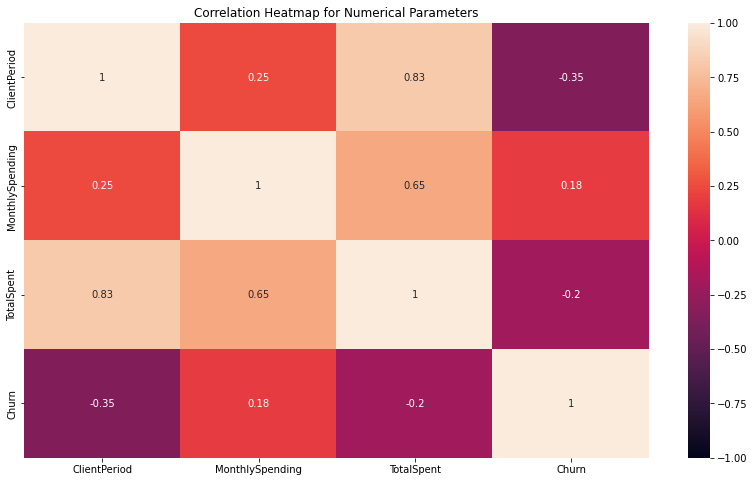

In [ ]:
plt.figure(figsize=(14, 8)) 
heatmap = sns.heatmap(train_data[num_cols + [target_col]].corr(), vmin=-1, vmax=1, annot=True);
heatmap.set_title('Correlation Heatmap for Numerical Parameters', fontdict={'fontsize':12});

As we can see, the classes of the target column are not well-balanced. *Class 1* is not colossally smaller than *Class 0*, so we can still avoid methods for processing imbalanced datasets, but keep in mind that the *accuracy* metric should not be used in this case.

---

## Linear model:


### Features preprocessing:



To convert categorical variables into numerical ones, it is necessary to convert several columns at once into numerical values, and then perform one-hot encoding:

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
# Label and OneHot encoding
labenc = LabelEncoder()

# Copy initial dataset for future catboost classifier
train_catboost = train_data.copy()
test_catboost = test_data.copy()

train_data[cat_cols] = train_data[cat_cols].apply(lambda col: labenc.fit_transform(col))
test_data[cat_cols] = test_data[cat_cols].apply(lambda col: labenc.fit_transform(col))

train_data = pd.get_dummies(train_data, columns=cat_cols)
test_data = pd.get_dummies(test_data, columns=cat_cols)

In [ ]:
train_data

,ClientPeriod,MonthlySpending,TotalSpent,Churn,Sex_0,Sex_1,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_0,HasPartner_1,...,HasMovieSubscription_2,HasContractPhone_0,HasContractPhone_1,HasContractPhone_2,IsBillingPaperless_0,IsBillingPaperless_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,55,19.50,1026.35,0,0,1,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,0,1,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,0,1,0,1,0,0,1,...,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
5278,50,44.45,2188.45,0,0,1,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
5279,1,55.05,55.05,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
5280,29,76.00,2215.25,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [ ]:
test_data

,ClientPeriod,MonthlySpending,TotalSpent,Sex_0,Sex_1,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_0,HasPartner_1,HasChild_0,...,HasMovieSubscription_2,HasContractPhone_0,HasContractPhone_1,HasContractPhone_2,IsBillingPaperless_0,IsBillingPaperless_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,42,56.10,2386.85,0,1,1,0,0,1,1,...,0,0,1,0,1,0,0,1,0,0
1,29,98.50,3004.15,0,1,0,1,0,1,1,...,1,1,0,0,0,1,0,0,1,0
2,9,76.25,684.85,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
3,67,74.00,4868.40,1,0,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
4,71,20.10,1389.60,1,0,1,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555.00,1,0,1,0,0,1,1,...,1,0,0,1,0,1,1,0,0,0
1757,13,20.85,272.35,1,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
1758,2,91.45,171.45,0,1,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1759,19,89.10,1620.80,1,0,1,0,0,1,1,...,1,1,0,0,0,1,0,0,1,0


In [ ]:
# Update names of the columns for train_test_split
num_cols_new = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
cat_cols_new = ['Sex_0',
       'Sex_1', 'IsSeniorCitizen_0', 'IsSeniorCitizen_1', 'HasPartner_0',
       'HasPartner_1', 'HasChild_0', 'HasChild_1', 'HasPhoneService_0',
       'HasPhoneService_1', 'HasMultiplePhoneNumbers_0',
       'HasMultiplePhoneNumbers_1', 'HasMultiplePhoneNumbers_2',
       'HasInternetService_0', 'HasInternetService_1', 'HasInternetService_2',
       'HasOnlineSecurityService_0', 'HasOnlineSecurityService_1',
       'HasOnlineSecurityService_2', 'HasOnlineBackup_0', 'HasOnlineBackup_1',
       'HasOnlineBackup_2', 'HasDeviceProtection_0', 'HasDeviceProtection_1',
       'HasDeviceProtection_2', 'HasTechSupportAccess_0',
       'HasTechSupportAccess_1', 'HasTechSupportAccess_2', 'HasOnlineTV_0',
       'HasOnlineTV_1', 'HasOnlineTV_2', 'HasMovieSubscription_0',
       'HasMovieSubscription_1', 'HasMovieSubscription_2',
       'HasContractPhone_0', 'HasContractPhone_1', 'HasContractPhone_2',
       'IsBillingPaperless_0', 'IsBillingPaperless_1', 'PaymentMethod_0',
       'PaymentMethod_1', 'PaymentMethod_2', 'PaymentMethod_3']

### Learning and optimization

In [ ]:
number_of_the_universe = 42

x_train, x_test, y_train, y_test = train_test_split(
    train_data[num_cols_new + cat_cols_new], train_data[target_col],
    random_state = number_of_the_universe,
    test_size = 0.2
)

params = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

clf = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', max_iter=1000, solver='saga'))
grid_search = GridSearchCV(
    estimator = clf,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = -1,
    refit = True,
    cv = 10
)

log_reg = grid_search.fit(x_train, y_train)

In [ ]:
print(f"Logistic Regression best score: {log_reg.best_score_}")
print(f"Logistic Regression best parameters: {log_reg.best_params_}")

Logistic Regression best score: 0.8496309810980229
Logistic Regression best parameters: {'logisticregression__C': 10}


In [ ]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = log_reg.predict_proba(test_data)[:, 1]
submission.to_csv('log_reg.csv', index=False)

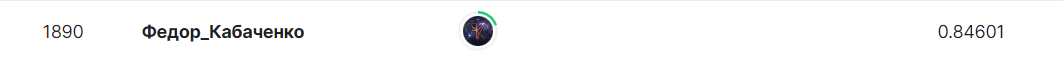

Best **C parameter** = 10

-----

## Gradient boosting:

In [ ]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb

### CatBoost Classifier

In [ ]:
number_of_the_universe = 42

x_train, x_test, y_train, y_test = train_test_split(
    train_catboost[num_cols + cat_cols], train_catboost[target_col],
    random_state = number_of_the_universe,
    test_size = 0.25
)


catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=number_of_the_universe,
)

params = {
    "n_estimators": [250], #np.arange(0, 500, 50)
    "learning_rate": [0.08], #np.arange(0.01, 0.1, 0.01)
    "max_depth": [4], #np.arange(1, 17, 1)
    "l2_leaf_reg": [6.3], #np.arange(0.1, 10, 0.1)
    "subsample": [0.6], #np.arange(0.6, 1, 0.01)
    "random_strength": [5], #np.arange(0.1, 10, 0.1)
    "min_data_in_leaf": [227], #np.arange(1, 1000, 1)

}

catboost.grid_search(params, x_train, y_train, cv=10, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8572750	best: 0.8572750 (0)	total: 1.5s	remaining: 0us
Estimating final quality...


{'params': {'min_data_in_leaf': 227,
  'random_strength': 5,
  'depth': 4,
  'iterations': 250,
  'subsample': 0.6,
  'learning_rate': 0.08,
  'l2_leaf_reg': 6.3},
 'cv_results': defaultdict(list,
             {'iterations': [0, 249],
              'test-AUC-mean': [0.7734449279097911, 0.8529039222017912],
              'test-AUC-std': [0.040203631991898116, 0.022524138152102954],
              'train-AUC-mean': [0.7753435460617448, 0.8811166421743346],
              'train-AUC-std': [0.006653368063811081, 0.0036147826410399034],
              'test-Logloss-mean': [0.6534946911012718, 0.40900408766244967],
              'test-Logloss-std': [0.0031328175714570024,
               0.027518399897379354],
              'train-Logloss-mean': [0.6531196169501406, 0.3728945666322655],
              'train-Logloss-std': [0.001572598197396235,
               0.004787339877596794]})}

In [ ]:
print("Best score:", end=' ')
print(catboost.best_score_)
best_params = catboost.get_params()
for f in ("cat_features", "logging_level", "eval_metric"):
    best_params.pop(f)
print("Best params:", end=' ')
print(best_params)

Best score: {'learn': {'Logloss': 0.37930077266882206, 'AUC': 0.8765591587127731}}
Best params: {'random_seed': 42, 'metric_period': 1000, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 227, 'random_strength': 5, 'depth': 4, 'iterations': 250, 'subsample': 0.6, 'learning_rate': 0.08, 'l2_leaf_reg': 6.3}


In [ ]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = catboost.predict_proba(test_catboost)[:, 1]
submission.to_csv("catboost.csv", index=False)

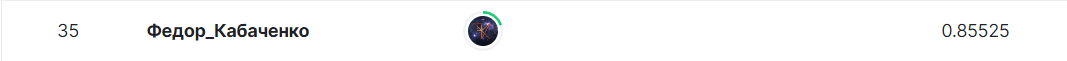

### XGBoost

In [ ]:
xgboost = XGBClassifier(
    seed = number_of_the_universe,
    objective = 'binary:logistic',
    n_jobs = -1,
)

params = {
    'booster': ['gbtree'], #['gbtree', 'gblinear']
    'n_estimators': [18], #np.arange(2, 20, 2)
    'eta': [0.2], #np.arange(0, 1, 0.1)
    'max_depth': [7], #np.arange(0, 10, 0.5)
    'min_child_weight': [8.0], #np.arange(0, 10, 0.5)
    'gamma': [0.1], #np.arange(0, 1, 0.05)
    'colsample_bytree': [0.45], #np.arange(0, 1, 0.05)
}


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    train_data[num_cols_new + cat_cols_new], train_data[target_col],
    random_state = number_of_the_universe,
    test_size = 0.25
)

search = GridSearchCV(
    estimator = xgboost,
    param_grid = params,
    scoring = 'roc_auc', 
    cv = 10,
    verbose = 100,
    n_jobs = -1,
    refit = True,
)

In [ ]:
search.fit(x_train, y_train)
print(f'Best parameters: {search.best_params_}')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'booster': 'gbtree', 'colsample_bytree': 0.45, 'eta': 0.2, 'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 8.0, 'n_estimators': 18}


In [ ]:
from sklearn.metrics import roc_auc_score
y_preds = search.predict_proba(x_test)[:, -1]
print(f"roc_auc of best XGBClassifier estimator: {roc_auc_score(y_test, y_preds)}")

roc_auc of best XGBClassifier estimator: 0.820186426939798


In [ ]:
submission = pd.read_csv("submission.csv")
submission["Churn"] = search.predict_proba(test_data)[:, 1]
submission.to_csv("xgboost.csv", index=False)

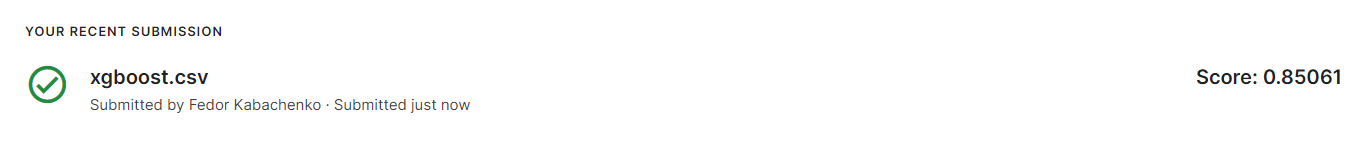

#### As a result, **CatBoost** works better on the given dataset:

1. CatBoost: 0.85525
2. XGBoost: 0.85061

---